In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import figure_factory as figfac
from termcolor import colored

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
from sklearn.metrics import mean_squared_error

In [3]:
!pip install keras-tuner --upgrade
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 28.1 MB/s 
     |████████████████████████████████| 1.6 MB 57.7 MB/s 
Required libraries were succesfully imported...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [6]:
df = pd.read_csv("/content/gold.csv")
fig = figfac.create_table(df.head(n = 10))
fig.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5703 entries, 0 to 5702
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      5703 non-null   object 
 1   Open      5703 non-null   float64
 2   High      5703 non-null   float64
 3   Low       5703 non-null   float64
 4   Close     5703 non-null   float64
 5   Volume    5703 non-null   int64  
 6   Currency  5703 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 312.0+ KB


In [8]:
df.describe().T.style.set_properties(**{"background-color": "#AB8111", "font-size" : "17px",
                                        "color": "#ffffff", "border-radius" : "1px", "border": "1.5px solid black"})

,count,mean,std,min,25%,50%,75%,max
Open,5703.000000,1040.382816,518.733377,256.600000,459.850000,1188.800000,1381.400000,2076.400000
High,5703.000000,1048.339181,522.353946,259.400000,463.900000,1198.000000,1392.750000,2089.200000
Low,5703.000000,1031.863169,514.455903,255.100000,457.450000,1179.700000,1368.100000,2049.000000
Close,5703.000000,1040.298282,518.524020,256.600000,460.500000,1188.700000,1383.050000,2069.400000
Volume,5703.000000,139141.669297,102537.449058,0.000000,52938.500000,126006.000000,193109.000000,816531.000000


In [9]:
df.rename(columns = {"Date" : "date", "Open" : "open", "High" : "high", "Low" : "low",
                     "Close" : "close", "Volume" : "volume", "Currency" : "currency"}, inplace = True)

print(colored("Column names were succesfully changed...", color = "green", attrs = ["bold", "dark"]))

Column names were succesfully changed...


In [10]:
print("Shape of the dataset: ", df.shape)
print("Length of the dataset: ", len(df))
print("Maximum closing price of gold during last twenty two years: ", df["close"].max())
print("Minimum closing price of gold during last twenty two years: ", df["close"].min())

Shape of the dataset:  (5703, 7)
Length of the dataset:  5703
Maximum closing price of gold during last twenty two years:  2069.4
Minimum closing price of gold during last twenty two years:  256.6


In [11]:
corr = df.corr()
corr.style.background_gradient(cmap = "copper")

,open,high,low,close,volume
open,1.000000,0.999879,0.999825,0.999740,0.692123
high,0.999879,1.000000,0.999778,0.999861,0.693861
low,0.999825,0.999778,1.000000,0.999893,0.688983
close,0.999740,0.999861,0.999893,1.000000,0.690534
volume,0.692123,0.693861,0.688983,0.690534,1.000000


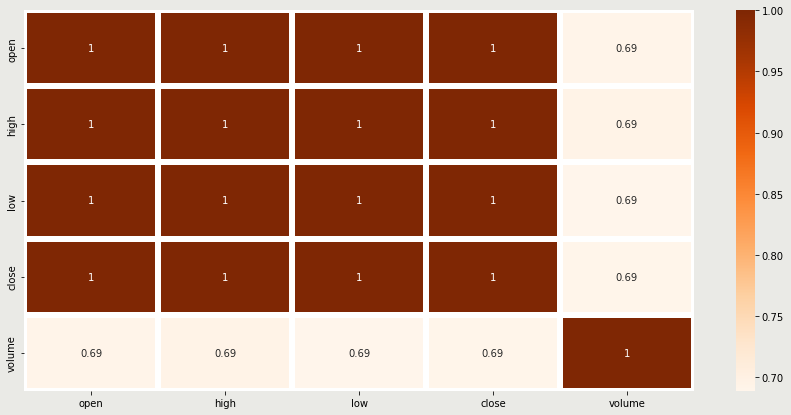

In [12]:
plt.figure(figsize = [15, 7], clear = True, facecolor = '#EAEAE6')
sns.heatmap(df.corr(), annot = True, square = False, linewidths = 5,
            linecolor = "white", cmap = "Oranges");

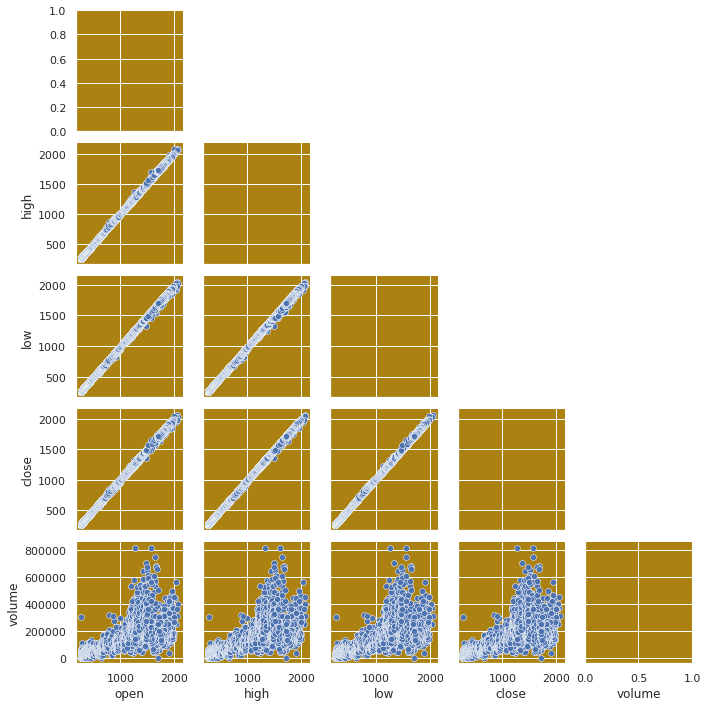

In [13]:
sns.set(rc={"axes.facecolor":"#AB8111", "figure.facecolor":"#ffffff"})
sns.pairplot(df, diag_kind = "reg", height = 2, aspect = 1, corner = True);

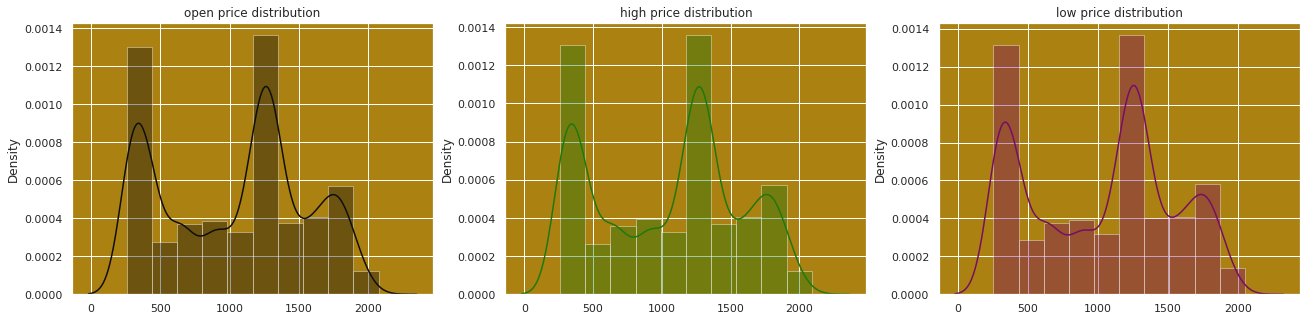

In [14]:
fig, axes = plt.subplots(1, 3, figsize = (22, 5))

sns.distplot(ax = axes[0], x = df["open"], hist = True, bins = 10, kde = True,
             vertical = False, color = "#0E0E0D").set(title = "open price distribution");

sns.distplot(ax = axes[1], x = df["high"], hist = True, bins = 10, kde = True,
             vertical = False, color = "#1F780D").set(title = "high price distribution");

sns.distplot(ax = axes[2], x = df["low"], hist = True, bins = 10, kde = True,
             vertical = False, color = "#780D62").set(title = "low price distribution");

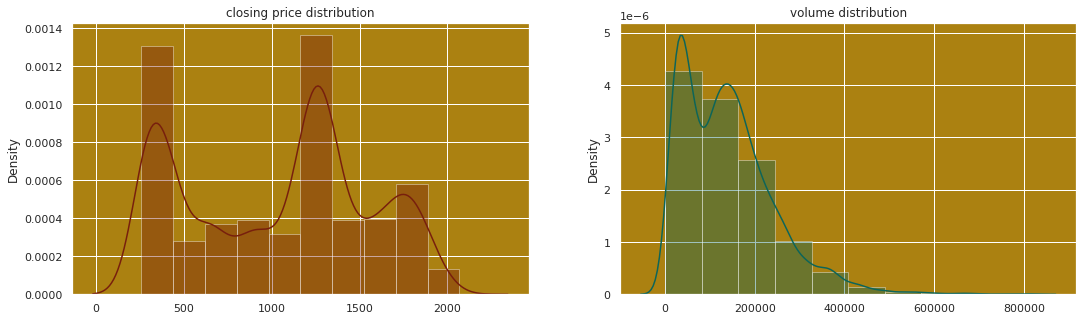

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (18, 5))

sns.distplot(ax = axes[0], x = df["close"], hist = True, bins = 10, kde = True,
             vertical = False, color = "#781F0D").set(title = "closing price distribution");

sns.distplot(ax = axes[1], x = df["volume"], hist = True, bins = 10, kde = True,
             vertical = False, color = "#0D6559").set(title = "volume distribution");

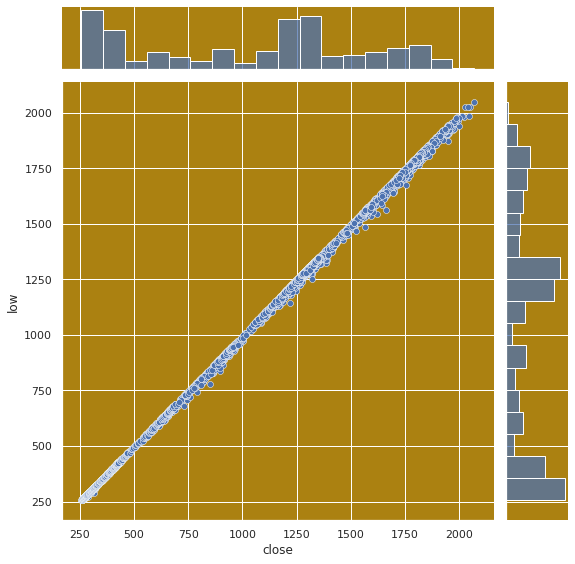

In [17]:
sns.jointplot(x = "close", y = "low", data = df, height = 8, ratio = 6, kind = "scatter");

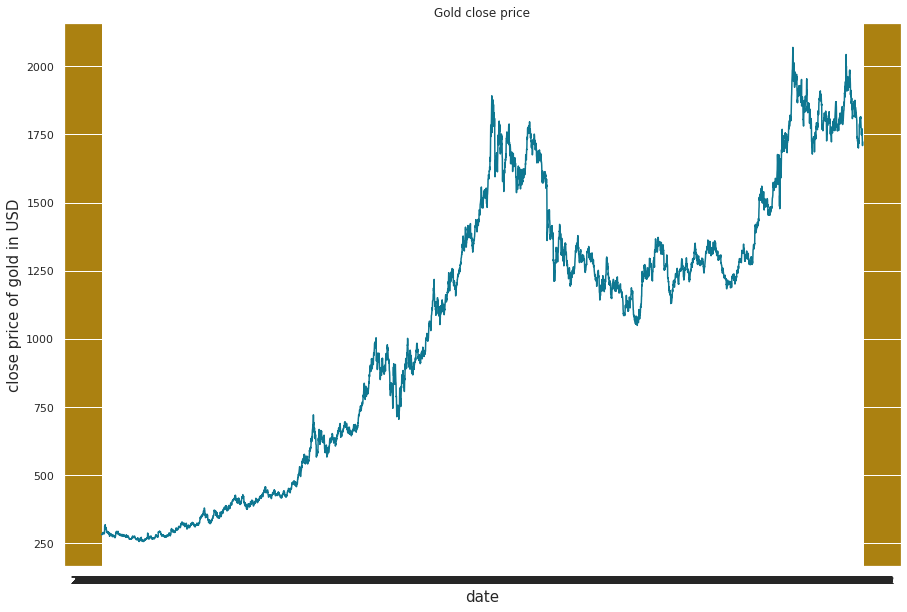

In [40]:
fig = plt.figure(figsize = (15, 10))

plt.plot(df["date"], df["close"], color = "#0E7791")
plt.title("Gold close price")
plt.xlabel("date", fontsize = 15)
plt.ylabel("close price of gold in USD", fontsize = 15)
plt.show()

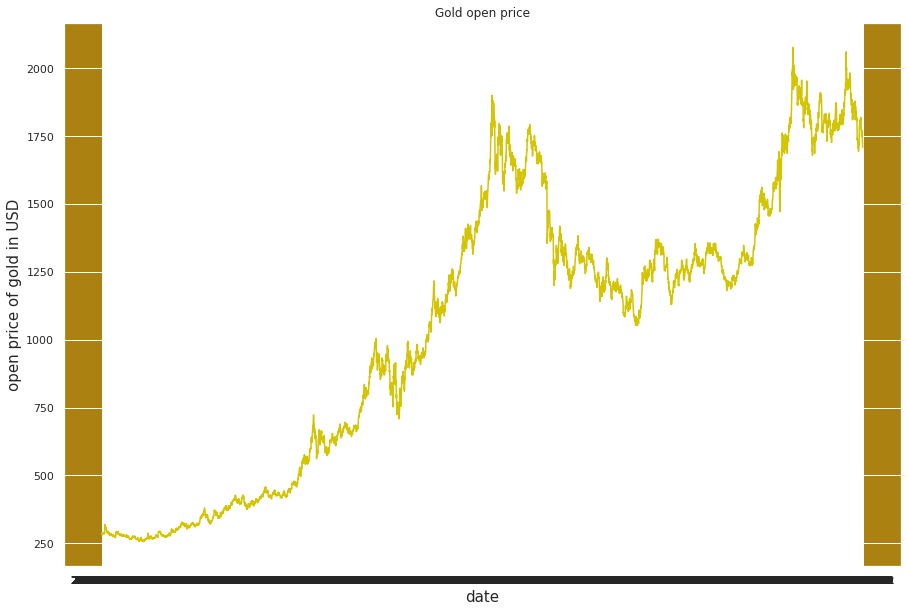

In [39]:
fig = plt.figure(figsize = (15, 10))

plt.plot(df["date"], df["open"], color = "#D3C404")
plt.title("Gold open price")
plt.xlabel("date", fontsize = 15)
plt.ylabel("open price of gold in USD", fontsize = 15)
plt.show()

In [23]:
fig = px.histogram(df, x = "close", y = "volume", marginal = "box", text_auto = True, template = "plotly_dark", hover_data  = df.columns)
fig.show()

Data Pre-Processing

In [24]:
data = df.filter(['close'])
data.head().style.set_properties(**{"background-color": "#AB8111", "font-size" : "17px",
                                    "color": "#ffffff", "border-radius" : "1px", "border": "1.5px solid black"})

,close
0,283.700000
1,282.100000
2,282.400000
3,282.900000
4,282.700000


In [26]:
dataset = data.values
dataset[0:5]

array([[283.7],
       [282.1],
       [282.4],
       [282.9],
       [282.7]])

In [27]:
training_data_len = int(np.ceil( len(dataset) * .95 ))
print("Training data length: ", training_data_len)

Training data length:  5418


Normalisation

In [28]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01494925],
       [0.01406664],
       [0.01423213],
       ...,
       [0.81067961],
       [0.80135702],
       [0.80891439]])

In [29]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train, "\n")
        print(y_train)

[array([0.01494925, 0.01406664, 0.01423213, 0.01450794, 0.01439762,
       0.01533539, 0.01494925, 0.01572154, 0.01561121, 0.01820388,
       0.01859003, 0.01803839, 0.01825905, 0.01737643, 0.01654898,
       0.01649382, 0.0168248 , 0.01621801, 0.01632833, 0.01588703,
       0.01715578, 0.01836937, 0.03111209, 0.02642321, 0.02487864,
       0.02868491, 0.0342564 , 0.03144307, 0.03000883, 0.02620256,
       0.02669903, 0.02603707, 0.02796778, 0.02818844, 0.02526478,
       0.02443733, 0.02096205, 0.02074139, 0.02074139, 0.02024492,
       0.01825905, 0.01859003, 0.01809356, 0.02046558, 0.01864519,
       0.01991395, 0.01842454, 0.01925199, 0.01825905, 0.01820388,
       0.01676964, 0.01566637, 0.01649382, 0.01864519, 0.01748676,
       0.01588703, 0.01572154, 0.01318402, 0.01263239, 0.01064651])] 

[0.012411738746690215]
[array([0.01494925, 0.01406664, 0.01423213, 0.01450794, 0.01439762,
       0.01533539, 0.01494925, 0.01572154, 0.01561121, 0.01820388,
       0.01859003, 0.01803839, 0.

In [30]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [31]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("The sape of x_train set:", x_train.shape)

The sape of x_train set: (5358, 60, 1)


In [32]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = "adam", loss = "mean_squared_error")

model.fit(x_train, y_train, batch_size = 1, epochs = 1)

5358/5358 [==============================] - 119s 22ms/step - loss: 8.4216e-04


In [33]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [34]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [42]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions[0:10]

9/9 [==============================] - 1s 52ms/step


array([[1782.7682],
       [1780.2621],
       [1776.431 ],
       [1774.7877],
       [1773.1665],
       [1771.4713],
       [1770.7532],
       [1770.5546],
       [1783.3278],
       [1787.1493]], dtype=float32)

In [36]:
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("RMSE score of the model:", rmse)

RMSE score of the model: 37.308737317729886


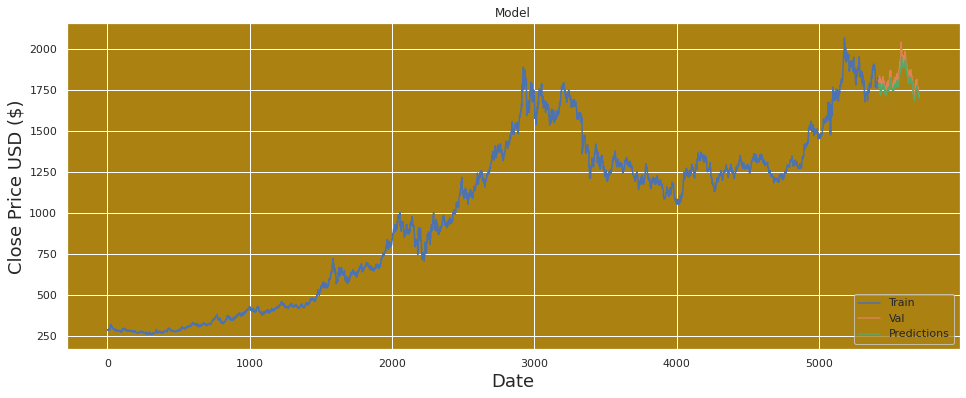

In [37]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

In [38]:
valid.head(n = 10)

,close,Predictions
5418,1811.4,1782.768188
5419,1803.4,1780.262085
5420,1805.4,1776.431030
5421,1801.8,1774.787720
5422,1799.2,1773.166504
5423,1799.8,1771.471313
5424,1799.7,1770.753174
5425,1835.8,1770.554565
5426,1817.2,1783.327759
5427,1822.2,1787.149292
